# Practical Session 2 — Spectral density estimation and periodogram

We aim to estimate the power spectral density (PSD) of a real, zero-mean, weakly stationary process $X_t$. We observe $X_t$ for $t \in \{0,1,\dots,n-1\}$ and will use the FFT (DFT implementation) from numpy.fft. Recall that the PSD $f_X(\lambda)$ is the DTFT ( Discrete Time Fourier Transform) of the autocovariance $\gamma(h)$:

$$f_X(\lambda)=\frac{1}{2\pi}\sum_{h\in\mathbb{Z}}\gamma(h)\,e^{-i\lambda h}.$$

For this exercise you will complete code to compute the periodogram and relate it to the empirical autocovariance.

[✍️]=write-up LaTeX or on paper, [💻]=implement with `python`

1. [✍️] Define the sample mean $\hat\mu_n=\frac{1}{n}\sum_{t=0}^{n-1}X_t$. For $h\ge 0$, define the empirical ACF estimator
    $$
    \hat\gamma_n(h)=
    \begin{cases}
    \frac{1}{n}\sum_{t=0}^{n-1-h}\big(X_t-\hat\mu_n\big)\big(X_{t+h}-\hat\mu_n\big), & h<n,\\[4pt]
    0, & h\ge n,
    \end{cases}
    $$
    $\quad\quad$ and for $h<0$ set $\hat\gamma_n(h)=\hat\gamma_n(|h|)$ (real process). Define the periodogram
    $$I_n(\lambda)=\frac{1}{2\pi}\sum_{h=-\,n+1}^{n-1}\hat\gamma_n(h)\,e^{-i\lambda h}.$$
    $\quad\quad$ Express $I_n(\lambda)$ as a function of the DTFT of the centered data $X_t-\hat\mu_n$.
2. [💻] Discrete grid computation.
   Deduce an algorithm to compute $I_n\!\left(\frac{2\pi k}{m}\right)$ for $k=0,\dots,m-1$, where $m\ge n$ is the DFT length. Test it on the processes from Practical Session 1.

3. [✍️💻] Recovering $\hat\gamma_n(h)$ from $I_n$.
   How can you obtain $\hat\gamma_n(h)$ from the discrete set $I_n\!\left(\frac{2\pi k}{m}\right)$? Which choice of m makes the relation simple (hint: zero-padding to avoid circular wrap-around)? Verify that your implementation matches a reference autocovariance routine.

4. [💻] White-noise variance experiment.
   For white noise, estimate the variance of the periodogram for several n and draw conclusions. (Expected: large variance that does not vanish with n unless you smooth/average.)


### 1)

##### Definitions

-   Centered Data: Let $Y_t=X_t-\hat\mu_n$ for $t\in\{0,\dots,n-1\}$

-   Empirical ACF: $\hat\gamma_n(h)=\mathbf{1}_{\{|h|<n\}}\big[\frac{1}{n}\sum_{t=0}^{n-1-|h|}{Y_tY_{t+|h|}}\big]$

-   Periodogram: $I_n(\lambda) = \frac{1}{2\pi} \sum_{h=-(n-1)}^{n-1} \hat\gamma_n(h) e^{-i\lambda h}$

-   DTFT of Data: Let's define $J(\lambda)$ as the DTFT of the finite sequence $Y_t$:$$J(\lambda) = \sum_{t=0}^{n-1} Y_t e^{-i\lambda t}$$

---

Let's analyze the squared magnitude of $J(\lambda)$:

$$|J(\lambda)|^2 = J(\lambda) \cdot \overline{J(\lambda)}$$

$$|J(\lambda)|^2 = \left( \sum_{t=0}^{n-1} Y_t e^{-i\lambda t} \right) \overline{\left( \sum_{s=0}^{n-1} Y_s e^{-i\lambda s} \right)}$$

Since the data $Y_s$ is real, the conjugate only applies to the complex exponential:

$$|J(\lambda)|^2 = \left( \sum_{t=0}^{n-1} Y_t e^{-i\lambda t} \right) \left( \sum_{s=0}^{n-1} Y_s e^{+i\lambda s} \right)$$

Expanding this product gives a double summation:

$$|J(\lambda)|^2 = \sum_{t=0}^{n-1} \sum_{s=0}^{n-1} Y_t Y_s e^{-i\lambda (t-s)}$$

This double sum over $t$ and $s$ is the key. Let's introduce a new variable for the lag, $h = t-s$. The maximum value for $h$ is $(n-1) - 0 = n-1$. The minimum value for $h$ is $0 - (n-1) = -(n-1)$. We can rewrite the double sum by summing over $h$ first, and then over all possible $t$ values for that $h$: $$|J(\lambda)|^2 = \sum_{h=-(n-1)}^{n-1} \left( \sum_{t} Y_t Y_{t-h} \right) e^{-i\lambda h}$$The inner sum is over all $t$ such that $t$ and $t-h$ are both in the range $[0, n-1]$. If $h \ge 0$, $t$ must go from $h$ to $n-1$. If $h < 0$, $t$ must go from $0$ to $n-1+h$.In both cases, the sum $\sum_{t} Y_t Y_{t-h}$ has $n-|h|$ terms.

Let's look at that inner sum, $c_h = \sum_{t} Y_t Y_{t-h}$.If $h \ge 0$, let $k=t-h$. The sum is $\sum_{k=0}^{n-1-h} Y_{k+h} Y_k$.If $h < 0$, let $k=t$. The sum is $\sum_{k=0}^{n-1-|h|} Y_k Y_{k+|h|}$. In all cases, this inner sum $c_h$ is exactly $\sum_{t=0}^{n-1-|h|} Y_t Y_{t+|h|}$.From the definition of $\hat\gamma_n(h)$, we know:

$$n \cdot \hat\gamma_n(h) = n \cdot \left( \frac{1}{n} \sum_{t=0}^{n-1-|h|} Y_t Y_{t+|h|} \right) = \sum_{t=0}^{n-1-|h|} Y_t Y_{t+|h|}$$

So, $c_h = n \cdot \hat\gamma_n(h)$.

Let's substitute this back into our expression for $|J(\lambda)|^2$:

$$|J(\lambda)|^2 = \sum_{h=-(n-1)}^{n-1} \left( n \cdot \hat\gamma_n(h) \right) e^{-i\lambda h}$$

$$|J(\lambda)|^2 = n \sum_{h=-(n-1)}^{n-1} \hat\gamma_n(h) e^{-i\lambda h}$$

Now, look at the definition of the periodogram:

$$I_n(\lambda) = \frac{1}{2\pi} \sum_{h=-(n-1)}^{n-1} \hat\gamma_n(h) e^{-i\lambda h}$$

By comparing the two equations, we can see:

$$\sum_{h=-(n-1)}^{n-1} \hat\gamma_n(h) e^{-i\lambda h} = \frac{1}{n} |J(\lambda)|^2$$

Plugging this into the $I_n(\lambda)$ formula gives our final result:

$$I_n(\lambda) = \frac{1}{2\pi n} |J(\lambda)|^2$$Or, written out in full:$$I_n(\lambda) = \frac{1}{2\pi n} \left| \sum_{t=0}^{n-1} (X_t - \hat\mu_n) e^{-i\lambda t} \right|^2$$

This result tells us that to compute the periodogram, we don't need to:

-   Center the data $X_t$.
-   Compute the autocovariance $\hat\gamma_n(h)$ for all lags.
-   Compute the Fourier transform of $\hat\gamma_n(h)$.

Instead, we can just:

-   Center the data $X_t$.
-   Compute the Fourier transform of the data itself.
-   Take the squared magnitude and scale it by $\frac{1}{2\pi n}$.

This is computationally much faster, especially when using the Fast Fourier Transform (FFT).


In [1]:
# Imports & helpers
# - center(x): enforce zero-mean data X_t - mu_hat
# - empirical_autocov: recall the empirical autocovariance

import numpy as np
import matplotlib.pyplot as plt


def center(x):
    x = np.asarray(x, dtype=float)
    return x - x.mean()


def empirical_mean(X):
    """Return sample mean."""
    return np.mean(X)


def empirical_autocov(X, h_max=None):
    """
    Empirical autocovariance for lags 0..h_max.
    ALSO: center with empirical_mean(X).
    """
    T = len(X)
    mu = empirical_mean(X)
    X_centered = X - mu
    if h_max is None:
        h_max = T - 1
    gamma = np.zeros(h_max + 1)
    for h in range(h_max + 1):
        gamma[h] = np.dot(X_centered[:T-h], X_centered[h:])/T

    return gamma

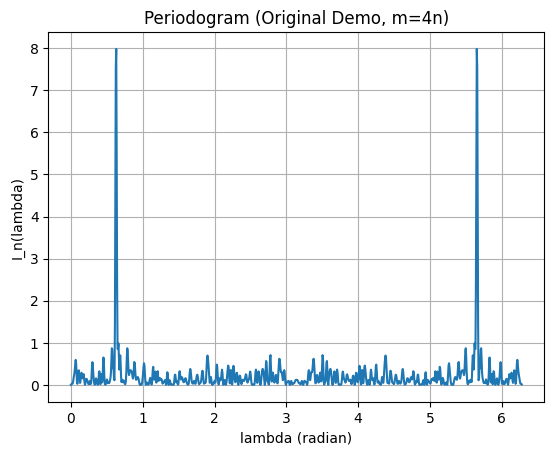

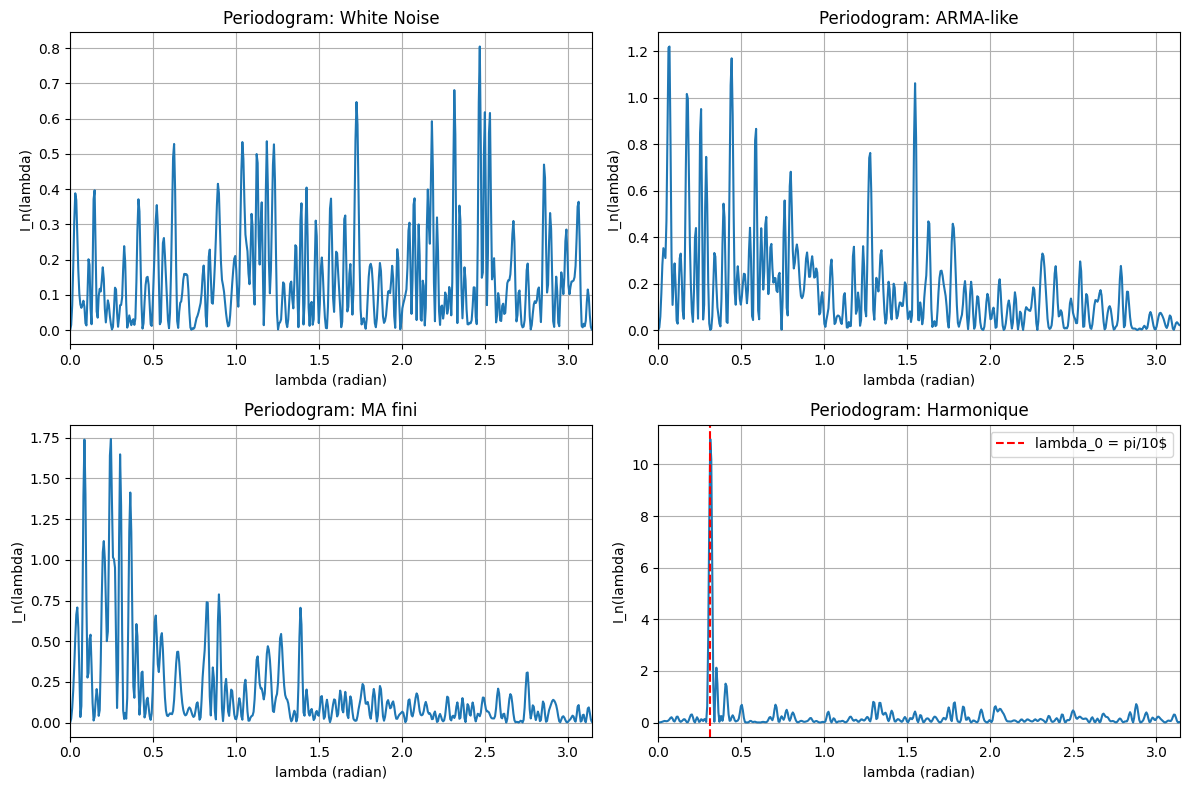

In [2]:
# (Task 2) Periodogram on a discrete grid via FFT
# I_n(λ_k) = |DFT(X - mu_hat, m)(k)|^2 / (2π n), where λ_k = 2πk/m.
# Implement and test on data from Practical Session 1

def periodogram_fft_centered(x, m=None):
    """
    Compute periodogram on the FFT grid for centered data.
    Args:
      x: 1D array, shape (n,)
      m: FFT length (>= n). If None, uses m = n.
    Returns:
      lam: array of λ_k = 2πk/m, k=0..m-1
      I:   I_n(λ_k)
      X:   FFT values for potential reuse
    """
    x = center(np.asarray(x, dtype=float))
    n = x.size
    if m is None:
        m = n

    X = np.fft.fft(x, m)

    I = (1 / (2 * np.pi * n)) * np.abs(X)**2

    lam = (2 * np.pi / m) * np.arange(m)

    return lam, I, X


# --- Simulation functions from Practical Session 1 ---
# (We need to define the parameters first)
sigma = 1.0
a = 0.0
b = 0.5
K = 50
A0 = 1.0
lambda0 = np.pi / 10


def simulate_WN(T):
    return np.random.normal(0, sigma, T)


def simulate_ARMA(T):
    Z = np.random.normal(0, sigma, T)
    Z_shifted = np.roll(Z, 1)
    Z_shifted[0] = 0
    return a + b * Z + Z_shifted


def simulate_MA(T):
    Z = np.random.normal(0, sigma, T + K)
    X_MA = np.zeros(T)
    coeffs = np.array([2 ** (-k) for k in range(K + 1)])
    for t in range(T):
        Z_slice_for_t = Z[t:t+K+1][::-1]
        X_MA[t] = a + np.dot(coeffs, Z_slice_for_t)
    return X_MA


def simulate_Harm(T):
    Phi0 = np.random.uniform(0, 2 * np.pi)
    Z = np.random.normal(0, sigma, T)
    t = np.arange(T)
    return A0 * np.cos(lambda0 * t + Phi0) + Z


# =======================
# ---- Original Demo ----
# =======================
n = 256
m_padding = 4 * n
x_orig = np.cos(2*np.pi*0.1*np.arange(n)) + np.random.normal(0, 1, n)

lam, I, _ = periodogram_fft_centered(x_orig, m=m_padding)

# Plot Original Demo
plt.figure()
plt.plot(lam, I)
plt.xlabel("lambda (radian)")
plt.ylabel("I_n(lambda)")
plt.title("Periodogram (Original Demo, m=4n)")
plt.grid(True)

# ===================================================
# ---- Demo for Practical Session 1 Processes ----
# ===================================================

processes_to_run = {
    "White Noise": simulate_WN,
    "ARMA-like": simulate_ARMA,
    "MA fini": simulate_MA,
    "Harmonique": simulate_Harm
}

plt.figure(figsize=(12, 8))

for i, (proc_name, sim_func) in enumerate(processes_to_run.items()):
    x_tp1 = sim_func(n)

    lam, I, _ = periodogram_fft_centered(x_tp1, m=m_padding)

    plt.subplot(2, 2, i + 1)
    plt.plot(lam, I)

    plt.xlim(0, np.pi)

    plt.title(f"Periodogram: {proc_name}")
    plt.xlabel("lambda (radian)")
    plt.ylabel("I_n(lambda)")

    if proc_name == "Harmonique":
        plt.axvline(x=lambda0, color='red', linestyle='--',
                    label=f"lambda_0 = pi/10$")
        plt.legend()

    plt.grid(True)

plt.tight_layout()

plt.show()

### 3)

We established the core relationship

$$I_n(\lambda) = \frac{1}{2\pi n} \left| \sum_{t=0}^{n-1} Y_t e^{-i\lambda t} \right|^2$$

When evaluated on the discrete FFT grid $\lambda_k = \frac{2\pi k}{m}$, this is:

$$I_n(\lambda_k) = \frac{1}{2\pi n} \left| \text{DFT}(Y, m)[k] \right|^2$$

(Here, $\text{DFT}(Y, m)$ is the DFT of $Y_t$ zero-padded to length $m$).

$$2\pi n \cdot I_n(\lambda_k) = \left| \text{DFT}(Y, m)[k] \right|^2$$

Now, let's consider the Inverse DFT (IDFT) of the right-hand side. The "Convolution Theorem" (or "Autocorrelation Theorem") states that the IDFT of the squared magnitude of a signal's DFT is the circular autocorrelation of that signal.

$$\text{IDFT}\left( \left| \text{DFT}(Y, m)[k] \right|^2 \right) \big[h\big] = r_{\text{circ}}[h]$$

where $r_{\text{circ}}[h]$ is the circular autocorrelation of $Y_t$ (padded to length $m$).

The circular autocorrelation $r_{\text{circ}}[h]$ wraps around. What we want is the standard linear autocorrelation, which (by the definition in your notebook) is $r_{\text{lin}}[h] = n \cdot \hat\gamma_n(h) = \sum_{t=0}^{n-1-h} Y_t Y_{t+h}$.The linear autocorrelation of a signal of length $n$ is a new sequence of length $2n-1$ (from lag $-(n-1)$ to $n-1$).The key idea: If we zero-pad our original signal $Y_t$ to a length $m$ such that $m \ge 2n-1$, the "wrap-around" from the circular correlation will happen in the zero-padded region. This makes the circular correlation exactly equal to the linear correlation for the lags we care about.

By choosing $m \ge 2n-1$:

$$r_{\text{circ}}[h] = r_{\text{lin}}[h] = n \cdot \hat\gamma_n(h) \quad \text{for } h = 0, \dots, n-1$$

Substituting back into our main equation:

$$\text{IDFT}\left( 2\pi n \cdot I_n(\lambda_k) \right) \big[h\big] = n \cdot \hat\gamma_n(h)$$

This simplifies to our final algorithm:

$$\hat\gamma_n(h) = 2\pi \cdot \text{IDFT}\left( I_n(\lambda_k) \right) \big[h\big]$$

or, more directly from the $\text{DFT}$ of the data:

$$\hat\gamma_n(h) = \frac{1}{n} \cdot \text{IDFT}\left( \left| \text{DFT}(Y, m)[k] \right|^2 \right) \big[h\big]$$


In [3]:
# (Task 3) Recover γ̂_n(h) from I_n via IDFT of |FFT|^2
# Theory: with zero-padding m >= 2n - 1, circular correlation equals linear correlation
# Practice: implement and verify against a direct empirical ACF.

def acov_from_periodogram_via_idft(x, m=None, n_max=None):
    """
    Compute γ̂_n(h) from IDFT(|FFT|^2) with adequate zero-padding.
    Args:
      x: data (1D array)
      m: FFT length; if None, use next power of 2 >= 2n-1
    Returns:
      acov: γ̂_n (1D array)
      m:    FFT length actually used
    """
    x = center(np.asarray(x, dtype=float))
    n = x.size

    if n_max is None:
        n_max = n

    if m is None:
        m = 1 << (2 * n - 2).bit_length()

    X = np.fft.fft(x, m)
    r_circ = np.fft.ifft(np.abs(X)**2)
    acov = np.real(r_circ[:n_max]) / n

    return acov, m


n = 256
x = np.cos(2*np.pi*0.1*np.arange(n)) + np.random.normal(0, 1, n)

# ---- Verification against direct computation ----
acov_fft, m_used = acov_from_periodogram_via_idft(x)
acov_emp = empirical_autocov(x, h_max=len(acov_fft)-1)
print("m used:", m_used)
print("max |diff| =", np.max(np.abs(acov_fft - acov_emp)))

m used: 512
max |diff| = 3.3306690738754696e-16


In [4]:
# (Task 3+) Reconstruct periodogram from γ̂_n to check the Fourier pair
# I_n(λ) = (1/2π) * sum_{h=-(n-1)}^{n-1} γ̂_n(h) e^{-iλh}

def periodogram_from_acov(acov, m):
    """
    Given acov[0..n-1], build symmetric sequence and FFT to sample I_n at λ_k = 2πk/m.
    """
    n = len(acov)
    g_sym = np.concatenate([acov, acov[1:][::-1]])  # length 2n-1
    if m < len(g_sym):
        raise ValueError("m must be >= 2n-1")
    g_pad = np.zeros(m, dtype=float)
    g_pad[:len(g_sym)] = g_sym
    G = np.fft.fft(g_pad)
    I = np.real(G) / (2*np.pi)
    lam = (2 * np.pi / m) * np.arange(m)
    return lam, I


# ---- Consistency check: direct periodogram vs acov->periodogram ----
m = 2048
lam1, I1, _ = periodogram_fft_centered(x, m=m)
acov, _ = acov_from_periodogram_via_idft(x, m=m, n_max=n)
lam2, I2 = periodogram_from_acov(acov, m=m)
print("grid equal:", np.allclose(lam1, lam2))
rmse = np.sqrt(np.mean((I1 - I2)**2))
print("RMSE between two routes:", rmse)

grid equal: True
RMSE between two routes: 0.6187801565684334


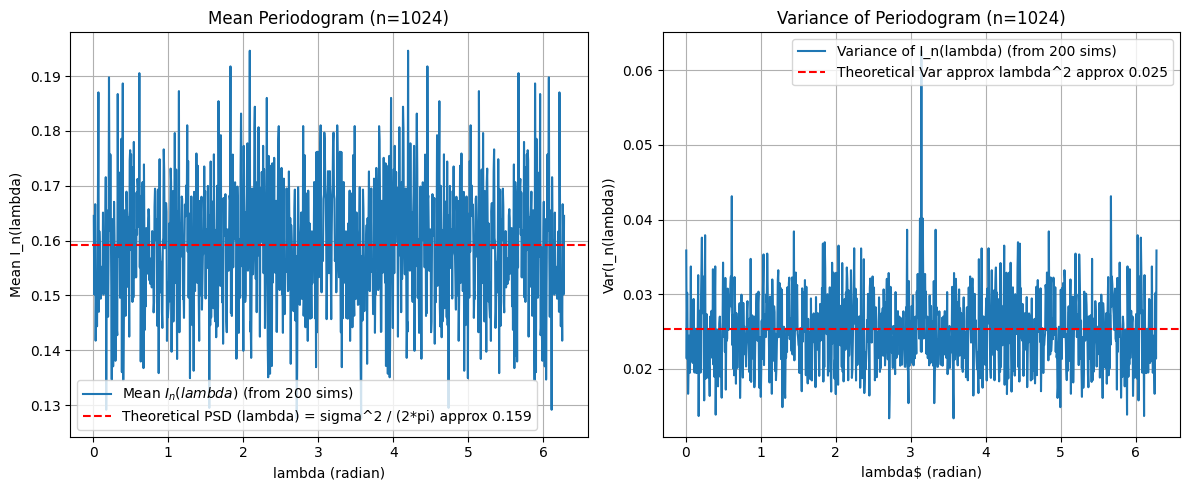

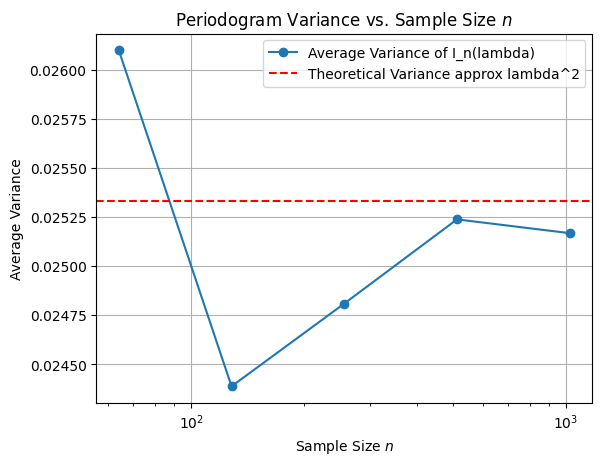

In [5]:
# (Task 4) White noise periodogram
# White-noise variance experiment.
# For white noise, estimate the variance of the periodogram for several n and draw conclusions.

sigma = 1.0
def simulate_WN(T):
    return np.random.normal(0, sigma, T)

# --- Parameters for the experiment ---
n_list = [64, 128, 256, 512, 1024]
n_simulations = 200 

avg_variances = []
all_variances = {}

for n in n_list:
    periodograms = np.zeros((n_simulations, n))
    
    for i in range(n_simulations):
        x_wn = simulate_WN(n)
        
        lam, I, _ = periodogram_fft_centered(x_wn, m=n)
        
        periodograms[i, :] = I
        
    var_at_each_k = np.var(periodograms[:, 1:], axis=0)
    
    if n == n_list[-1]:
        all_variances['mean_I'] = np.mean(periodograms[:, 1:], axis=0)
        all_variances['var_I'] = var_at_each_k
        all_variances['lam'] = lam[1:] # type: ignore
        
    # Store the average variance
    avg_variances.append(np.mean(var_at_each_k))

# --- Theoretical values for WN(0, sigma^2) ---
psd_theo = sigma**2 / (2 * np.pi)
var_theo = psd_theo**2

# --- Plot 1: Analysis for largest n ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(all_variances['lam'], all_variances['mean_I'], label='Mean $I_n(lambda)$ (from 200 sims)')
plt.axhline(y=psd_theo, color='red', linestyle='--', label=f'Theoretical PSD (lambda) = sigma^2 / (2*pi) approx {psd_theo:.3f}')
plt.title(f'Mean Periodogram (n={n_list[-1]})')
plt.xlabel('lambda (radian)')
plt.ylabel('Mean I_n(lambda)')
plt.legend()
plt.grid(True)

# Plot the variance of the periodogram
plt.subplot(1, 2, 2)
plt.plot(all_variances['lam'], all_variances['var_I'], label='Variance of I_n(lambda) (from 200 sims)')
plt.axhline(y=var_theo, color='red', linestyle='--', label=f'Theoretical Var approx lambda^2 approx {var_theo:.3f}')
plt.title(f'Variance of Periodogram (n={n_list[-1]})')
plt.xlabel('lambda$ (radian)')
plt.ylabel('Var(I_n(lambda))')
plt.legend()
plt.grid(True)

plt.tight_layout()

# --- Plot 2: Average variance vs. n ---
plt.figure()
plt.plot(n_list, avg_variances, 'o-', label='Average Variance of I_n(lambda)')
plt.axhline(y=var_theo, color='red', linestyle='--', label='Theoretical Variance approx lambda^2')
plt.title('Periodogram Variance vs. Sample Size $n$')
plt.xlabel('Sample Size $n$')
plt.ylabel('Average Variance')
plt.xscale('log')
plt.legend()
plt.grid(True)

Mean: The "Mean Periodogram" (left plot) is approximately flat and very close to the red dashed line. This shows that the periodogram is asymptotically unbiased, meaning $\mathbb{E}[I_n(\lambda)] \to f_X(\lambda)$ as $n$ gets large. On average, it correctly estimates the true Power Spectral Density (PSD).Variance: The "Variance of Periodogram" (right plot) is also approximately flat and close to its theoretical value, $[f_X(\lambda)]^2$.

This is the most important result. The plot shows the average variance of the periodogram as a function of the sample size, $n$. You will see that the blue line is roughly flat. It does not decrease as $n$ increases from 64 to 1024.Conclusion: This demonstrates that the periodogram is an inconsistent estimator of the spectral density. While its mean is correct (it's unbiased), its variance does not go to zero as $n \to \infty$. This means that even with a very long signal, the periodogram itself will still be extremely noisy and not a good, stable estimate of the true PSD.This result is the main motivation for using smoothing techniques, such as windowing (like Bartlett's or Welch's methods), which average periodograms over time or frequency to trade bias for a crucial reduction in variance.